In [1]:
!pip install datasets transformers torch

In [1]:
from datasets import Dataset, load_dataset
import os

path = os.path.join(os.getcwd(), "GasHisSDB")
full_dataset = load_dataset("imagefolder", data_dir=path, drop_labels=False)

/home/barrafas/python/machine_learning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 33284/33284 [00:00<00:00, 38497.13it/s] 
Found cached dataset imagefolder (/home/barrafas/.cache/huggingface/datasets/imagefolder/default-e6078c0d2e159711/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


In [2]:
splits = full_dataset["train"].train_test_split(test_size=0.2)
train_ds = splits["train"]
test_ds = splits["test"]

splits = train_ds.train_test_split(test_size=0.2)
train_ds = splits["train"]
val_ds = splits["test"]

In [3]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Abnormal', 1: 'Normal'}

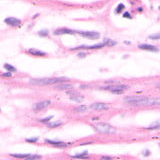

In [4]:
train_ds[0]["image"]

In [5]:
id2label[train_ds[0]['label']]

'Normal'

In [6]:
from transformers import ViTImageProcessor

model_checkpoint = "google/vit-base-patch16-224-in21k"

processor = ViTImageProcessor.from_pretrained(model_checkpoint)
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [8]:
# transformações das imagens de entrada do modelo
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [9]:
# as transformações ocorrem on-the-fly quando cada imagem é chamada
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [10]:
# Vanos agora trabalhar com dataloaders do pytorch:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 2
eval_batch_size = 2

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size, num_workers=12)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size, num_workers=12)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size, num_workers=12)

In [11]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


In [12]:
# Definindo modelo pytorch:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=2):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                              num_labels=2,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_accuracy", accuracy, on_epoch=True)

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return torch.optim.AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

In [13]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 3026), started 4:08:53 ago. (Use '!kill 3026' to kill it.)

In [13]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

torch.set_float32_matmul_precision('high')
# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
# model.load_from_checkpoint("lightning_logs/version_13/checkpoints/epoch=8-step=95859.ckpt")
trainer = Trainer(callbacks=[EarlyStopping(monitor='validation_loss')], max_epochs=15)
# trainer.fit(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used

In [17]:
trainer.test(model, ckpt_path="lightning_logs/version_13/checkpoints/epoch=8-step=95859.ckpt")

Restoring states from the checkpoint path at lightning_logs/version_13/checkpoints/epoch=8-step=95859.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs/version_13/checkpoints/epoch=8-step=95859.ckpt


Testing DataLoader 0: 100%|██████████| 1665/1665 [00:31<00:00, 53.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9729607701301575
        test_loss           0.07517245411872864
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.07517245411872864, 'test_accuracy': 0.9729607701301575}]

In [19]:
# torch.save(model.state_dict(), "ViT_GasHisSDB.pt")

In [14]:
model2 = ViTLightningModule()
model2.load_state_dict(torch.load("ViT_GasHisSDB.pt"))

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [16]:
# get prediction matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = []
y_pred = []
model.eval()
for batch in test_dataloader:
    y_true.extend(batch['labels'].tolist())
    y_pred.extend(model(batch['pixel_values']).argmax(-1).tolist())

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

KeyboardInterrupt: 